In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [75]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
tags = ["O", "B", "I"]
tag_to_index = {k:v for v,k in enumerate(tags)}
from keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
path = "/content/drive/My Drive/assignment2dataset/"
import os
f = open(os.path.join(path,"train.txt"))

# Chunking Using Bi-LSTM (only POS Tags)



> Indented block



In [ ]:
def load_data_bilstm_pos_tags(file):
	# Opening file 
  f = open(file, 'r') 
  sents = []
  sent = []
  word_num = {}
  word_num['^'] = 0
  word_num['OOV'] = 1
  count = 2
  sents_tags = []
  sent = [0]
  sent_tags = [0]
  for line in f:
    cur_line = line.strip()
    if not cur_line:
      sents.append(sent)
      sents_tags.append(sent_tags)
      sent = [0]
      sent_tags = [0]
    else:
      cur_line_list = cur_line.split(" ")
      key = tuple(cur_line_list[1])
      if key not in word_num:
          word_num[key] = count
          count += 1
      cur_line_list[2] = cur_line_list[2][0]
      sent.append(word_num[key])
      sent_tags.append(tag_to_index[cur_line_list[2]])

  return sents, word_num,count, sents_tags
sents, word_num,count, sents_tags = load_data_bilstm_pos_tags(os.path.join(path,"train.txt"))
assert len(sents) == len(sents_tags)
for i in range(len(sents)):
  assert len(sents[i]) == len(sents_tags[i])

In [ ]:
def one_hot(sequences, num_categories):
	one_hot_sequences = []
	for s in sequences:
		one_hot_seq = []
		for i in s:
			one_hot_seq.append(np.zeros(num_categories))
			one_hot_seq[-1][i] = 1.0
		one_hot_sequences.append(one_hot_seq)
	return np.array(one_hot_sequences)

In [ ]:
MAX_LEN = len(max(sents, key=len))
def pad_sentences(sent_words_labelled, sent_tags_labelled,MAX_LEN):
	sent_words_labelled = pad_sequences(sent_words_labelled, maxlen = MAX_LEN, padding='post')
	sent_tags_labelled = pad_sequences(sent_tags_labelled, maxlen = MAX_LEN, padding='post')
	return sent_words_labelled, sent_tags_labelled

train_words, train_tags = pad_sentences(sents, sents_tags,MAX_LEN)
def ignore_class_accuracy(to_ignore=0):
    def ignore_accuracy(y_true, y_pred):
        y_true_class = K.argmax(y_true, axis=-1)
        y_pred_class = K.argmax(y_pred, axis=-1)
 
        ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy
    return ignore_accuracy

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation
from tensorflow.keras.optimizers import Nadam
import nltk
from sklearn.metrics import confusion_matrix
model = Sequential()
model.add(InputLayer(input_shape=(len(max(sents, key=len)), )))
model.add(Embedding(count, 128))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(len(tags))))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Nadam(0.001),metrics=['accuracy',ignore_class_accuracy(0)])

In [ ]:
train_tags = np.asarray(one_hot(train_tags, len(tags)))

In [ ]:
model.fit(np.asarray(train_words),train_tags, batch_size=128, epochs=30)

Epoch 1/100
70/70 [==============================] - 118s 2s/step - loss: 0.3722 - accuracy: 0.8193 - ignore_accuracy: 0.4958
Epoch 2/100
70/70 [==============================] - 119s 2s/step - loss: 0.1544 - accuracy: 0.9379 - ignore_accuracy: 0.7790
Epoch 3/100
70/70 [==============================] - 118s 2s/step - loss: 0.0799 - accuracy: 0.9733 - ignore_accuracy: 0.9067
Epoch 4/100
70/70 [==============================] - 121s 2s/step - loss: 0.0698 - accuracy: 0.9766 - ignore_accuracy: 0.9190
Epoch 5/100
70/70 [==============================] - 118s 2s/step - loss: 0.0658 - accuracy: 0.9778 - ignore_accuracy: 0.9231
Epoch 6/100
70/70 [==============================] - 118s 2s/step - loss: 0.0625 - accuracy: 0.9788 - ignore_accuracy: 0.9269
Epoch 7/100
70/70 [==============================] - 118s 2s/step - loss: 0.0592 - accuracy: 0.9801 - ignore_accuracy: 0.9317
Epoch 8/100
70/70 [==============================] - 118s 2s/step - loss: 0.0549 - accuracy: 0.9821 - ignore_accuracy:

KeyboardInterrupt: ignored

In [69]:
def obt_test_data(file,word_num):
	# Opening file 
  f = open(file, 'r') 
  sents = []
  sent = []
  sents_tags = []
  sent = [0]
  sent_tags = [0]
  len_sentences = []
  len_sentence = 0
  for line in f:
    cur_line = line.strip()
    if not cur_line:
      sents.append(sent)
      sents_tags.append(sent_tags)
      sent = [0]
      sent_tags = [0]
      len_sentences.append(len_sentence)
      len_sentence = 0
    else:
      cur_line_list = cur_line.split(" ")
      cur_line_list[0] = cur_line_list[0].lower()
      cur_line_list[2] = cur_line_list[2][0]
      key = tuple(cur_line_list[1])
      if key not in word_num:
        sent.append(1)
      else:
        sent.append(word_num[key])
      len_sentence+=1
      sent_tags.append(tag_to_index[cur_line_list[2]])
  len_sentencs = np.asarray(len_sentences)
  return sents, sents_tags, len_sentences
test_sents, test_sents_tags,len_sentences = obt_test_data(os.path.join(path,"test.txt"), word_num)
test_words, test_tags = pad_sentences(test_sents, test_sents_tags,MAX_LEN)
test_tags_one_hot = np.asarray(one_hot(test_tags,3))
model.evaluate(
    test_words, test_tags_one_hot
    )
Y_pred = model.predict(
    test_words, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10,
    workers=1, use_multiprocessing=False
)

[[0 1 2 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]]
63/63 [==============================] - 10s 163ms/step - loss: 0.0396 - accuracy: 0.9877 - ignore_accuracy: 0.9592


In [70]:
Y_pred = np.argmax(Y_pred,axis = 2)

In [71]:
final_y_pred_mux = []
final_y_true_mux = []
assert len(len_sentences) == Y_pred.shape[0]
for i in range(Y_pred.shape[0]):
  final_y_pred_mux.append(Y_pred[i,1:1+len_sentences[i]])
  final_y_true_mux.append(test_tags[i, 1:1+len_sentences[i]])

final_y_pred = [val for el in final_y_pred_mux for val in el]
final_y_true = [val for el in final_y_true_mux for val in el]


Y_pred = Y_pred.flatten()
test_tags = test_tags.flatten()

from sklearn.metrics import confusion_matrix
print(confusion_matrix(final_y_true, final_y_pred))

[[ 5914   133   133]
 [   51 23214   587]
 [  228   824 16293]]


In [72]:
from sklearn.metrics import classification_report
print(classification_report(final_y_true, final_y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      6180
           1       0.96      0.97      0.97     23852
           2       0.96      0.94      0.95     17345

    accuracy                           0.96     47377
   macro avg       0.96      0.96      0.96     47377
weighted avg       0.96      0.96      0.96     47377



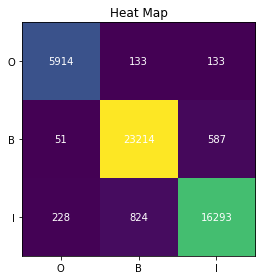

In [76]:
from matplotlib import pyplot as plt
%matplotlib inline
conf_matr = confusion_matrix(test_tags, Y_pred)
fig, ax = plt.subplots()
#Since we ignore data originally from O
conf_matr = confusion_matrix(final_y_true, final_y_pred)
im = ax.imshow(conf_matr)

ax.set_xticks(np.arange(len(tags)))
ax.set_yticks(np.arange(len(tags)))
# ... and label them with the respective list entries
ax.set_xticklabels(tags)
ax.set_yticklabels(tags)

# # Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(tags)):
    for j in range(len(tags)):
        text = ax.text(j, i, conf_matr[i,j],
                       ha="center", va="center", color="w")

ax.set_title("Heat Map")
fig.tight_layout()
plt.show()

In [20]:
model.save(os.path.join(path,"only_pos.h5"))

#Error Analysis Code (Please Ignore)

In [39]:
count = 0
wrong_sentences = []
wrong_sentences_results = []
for i in range(1000):
  sentence= np.asarray([test_words[i]])
  tags = np.asarray([test_tags_one_hot[i]])
  result = model.evaluate(sentence, tags)
  if result[-1] < 1:
    wrong_sentences.append(i)
    wrong_sentences_results.append(model.predict(sentence))
    count+=1
  if count > 60:
    break
print(wrong_sentences)

1/1 [==============================] - 0s 1ms/step - loss: 0.0533 - accuracy: 0.9747 - ignore_accuracy: 0.6000
[2, 4, 12, 14, 16, 19, 21, 22, 24, 25, 26, 27, 32, 34, 35, 38, 39, 42, 43, 44, 47, 48, 49, 50, 52, 53, 55, 58, 59, 64, 65, 67, 68, 71, 72, 74, 75, 78, 81, 85, 86, 87, 88, 89, 90, 92, 95, 97, 98, 99, 102, 105, 107, 108, 111, 113, 114, 116, 118, 119, 120]


TypeError: ignored

In [45]:
def lines(file ):
  count = 0
	# Opening file 
  f = open(file, 'r') 
  sents = []
  sent = []
  for line in f:
    cur_line = line.strip()
    if not cur_line:
      sents.append(sent)
      sent = []
    else:
      cur_line_list = cur_line.split(" ")
      cur_line_list[2] = cur_line_list[2][0]
      sent.append(cur_line_list[0])
  return sents
      

In [57]:
def num_to_tags(nums):
  labels = ["O", "B", "I"]
  answer = []
  for num in nums:
    answer.append(labels[num])
  return answer

In [63]:
all_test_sents = lines(os.path.join(path,"test.txt"))
print(num_to_tags(test_sents_tags[119]))
print(num_to_tags((np.argmax(wrong_sentences_results[-2], axis = 2)).squeeze())[:len(all_test_sents[119])+2])


['O', 'B', 'I', 'B', 'O', 'B', 'I', 'I', 'O', 'B', 'B', 'B', 'O', 'B', 'B', 'I', 'O', 'B', 'I', 'I', 'O', 'B', 'I', 'O', 'O', 'B', 'I', 'B', 'B', 'B', 'I', 'B', 'B', 'I', 'B', 'B', 'B', 'I', 'B', 'B', 'I', 'O']
['O', 'B', 'I', 'B', 'B', 'I', 'I', 'I', 'O', 'B', 'B', 'I', 'O', 'B', 'B', 'I', 'O', 'B', 'O', 'B', 'O', 'B', 'I', 'O', 'O', 'B', 'I', 'B', 'B', 'B', 'I', 'B', 'B', 'I', 'B', 'B', 'B', 'I', 'B', 'B', 'I', 'O', 'O']


In [53]:
print(all_test_sents[11])

['Is', 'such', 'a', 'view', 'justified', '?']
